In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Dataset 1: Sine wave with noise

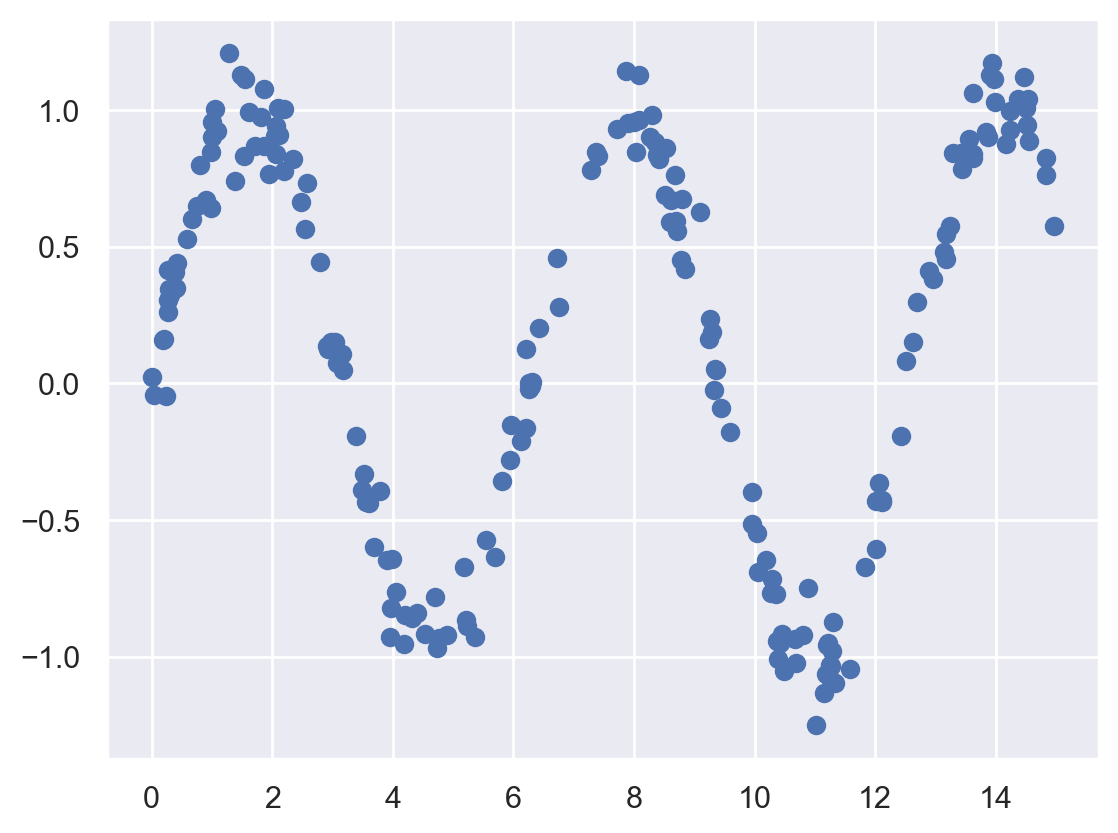

In [2]:
# Generate some data
rng = np.random.RandomState(1)
x = 15 * rng.rand(200)
y = np.sin(x) + 0.1 * rng.randn(200)
df = pd.DataFrame({'x': x, 'y': y})

# plot the data
plt.scatter(df.x, df.y)
plt.show()

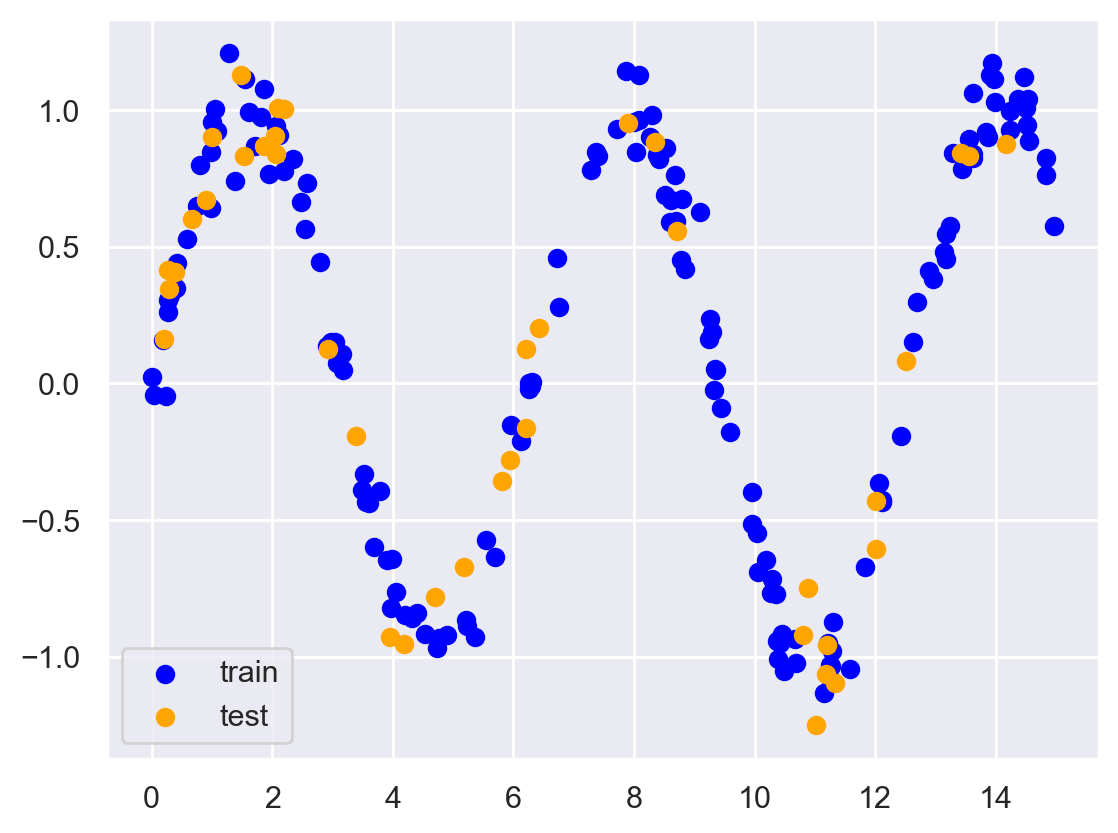

In [3]:
# Train test split
train = df.sample(frac=0.8, random_state=1)
test = df.drop(train.index)

plt.scatter(train.x, train.y, color='blue', label='train')
plt.scatter(test.x, test.y, color='orange', label='test')
plt.legend()
plt.show()

In [4]:
def plot_predictions(train, test, yhat_train, yhat_test):
        
    # add yhat_train to train and yhat_test to test
    train['yhat'] = yhat_train
    test['yhat'] = yhat_test

    # sort train and test by x
    train = train.sort_values(by='x')
    test = test.sort_values(by='x')

    # Train and test error
    train_rmse = np.sqrt(np.mean((train.yhat - train.y)**2))
    test_rmse = np.sqrt(np.mean((test.yhat - test.y)**2))

    plt.scatter(train.x, train.y, color='blue', label='train')
    plt.scatter(test.x, test.y, color='orange', label='test')
    plt.plot(train.x, train.yhat, color='red', label='train prediction')
    plt.plot(test.x, test.yhat, color='green', label='test prediction')
    plt.title('Train RMSE: {:.3f}, Test RMSE: {:.3f}'.format(train_rmse, test_rmse))
    plt.legend()
    plt.show()

    return train_rmse, test_rmse

In [5]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
def hyperparameter_tuning(params, train, test, model):
    train_rmse = []
    test_rmse = []

    for d in params:
        yhat_train, yhat_test = model(d, train, test)
        train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
        test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

    plt.plot(params, train_rmse, label='train')
    plt.plot(params, test_rmse, label='test')
    plt.xlabel('params')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    optimal_param = params[np.argmin(test_rmse)]

    return optimal_param

In [6]:
rmse_dict = {}

### Model 1: MLP

In [7]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)
mlp_model.fit(np.array(train.x).reshape(-1, 1), train.y)

MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter=10000)

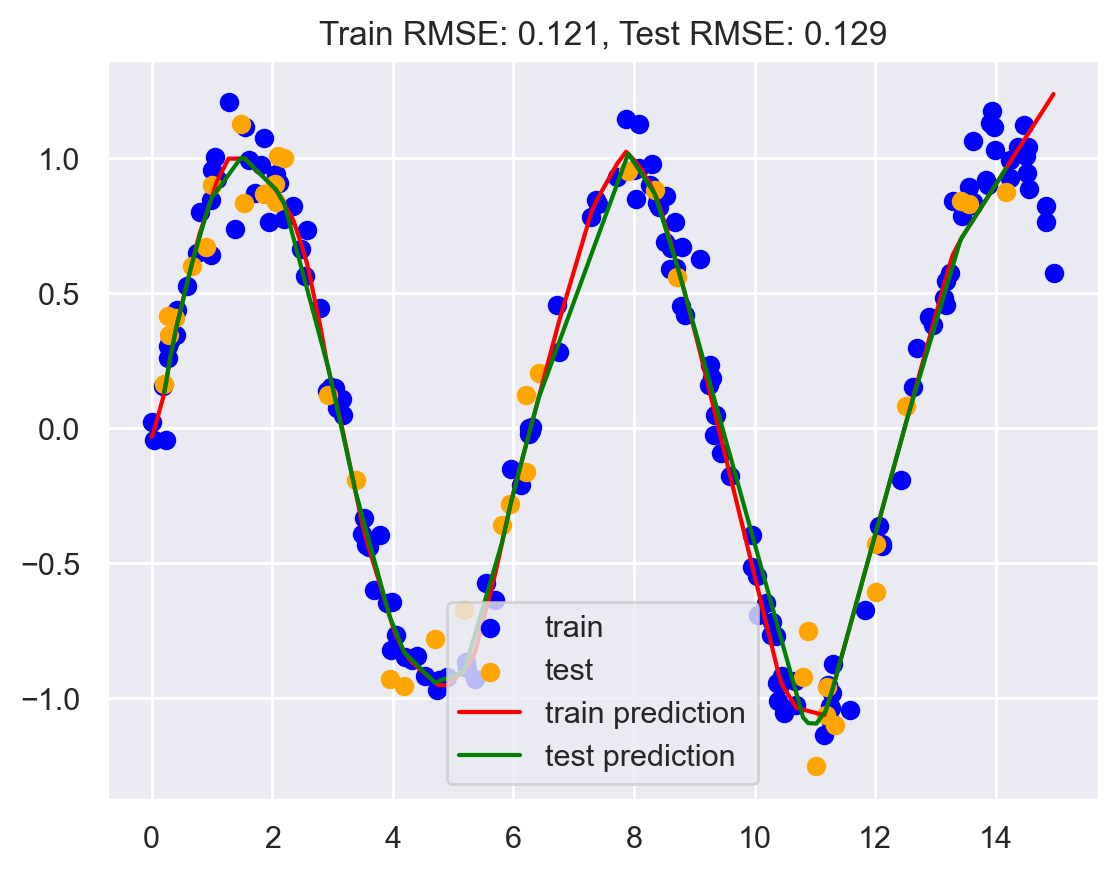

In [8]:
yhat_train = mlp_model.predict(np.array(train.x).reshape(-1, 1))
yhat_test = mlp_model.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['MLP'] = (train_rmse, test_rmse)

### Model 2: Vanilla Linear Regression

In [10]:
lr1 = LinearRegression()
lr1.fit(np.array(train.x).reshape(-1, 1), train.y)

LinearRegression()

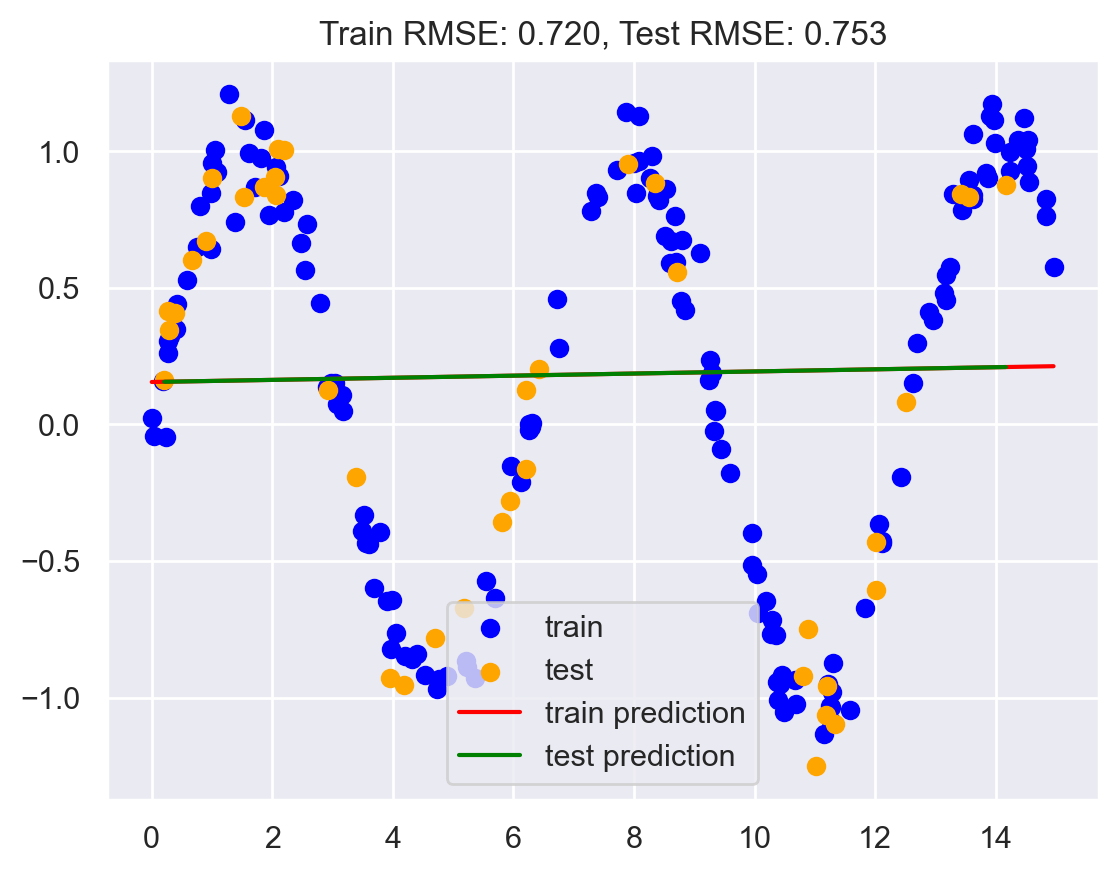

In [11]:
yhat_train = lr1.predict(np.array(train.x).reshape(-1, 1))
yhat_test = lr1.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Vanilla LR'] = (train_rmse, test_rmse)

### Model 3: Polynomial regression with degree d

In [12]:
def poly_regression(d, train, test):
    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    
    X_train = pf.fit_transform(train.x.values.reshape(-1, 1))
    X_test = pf.fit_transform(test.x.values.reshape(-1, 1))
    
    lr.fit(X_train, train.y)
    
    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

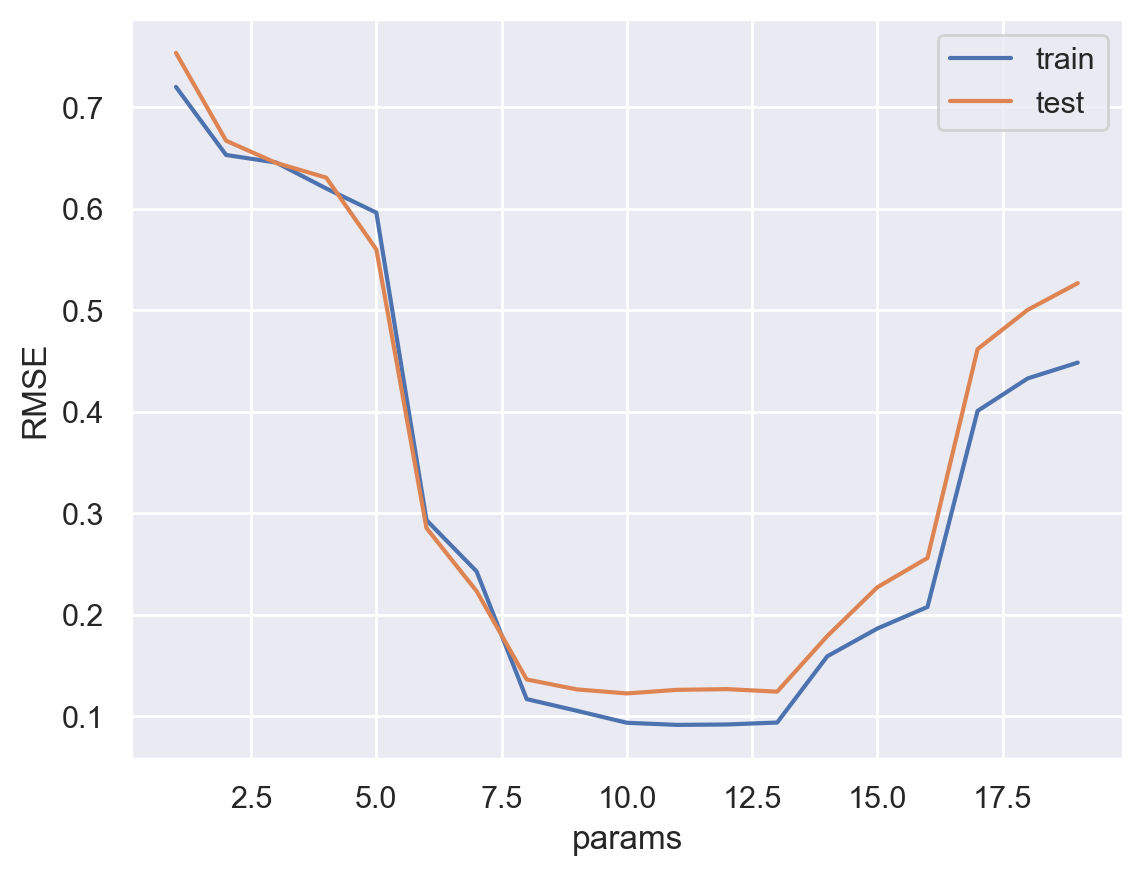

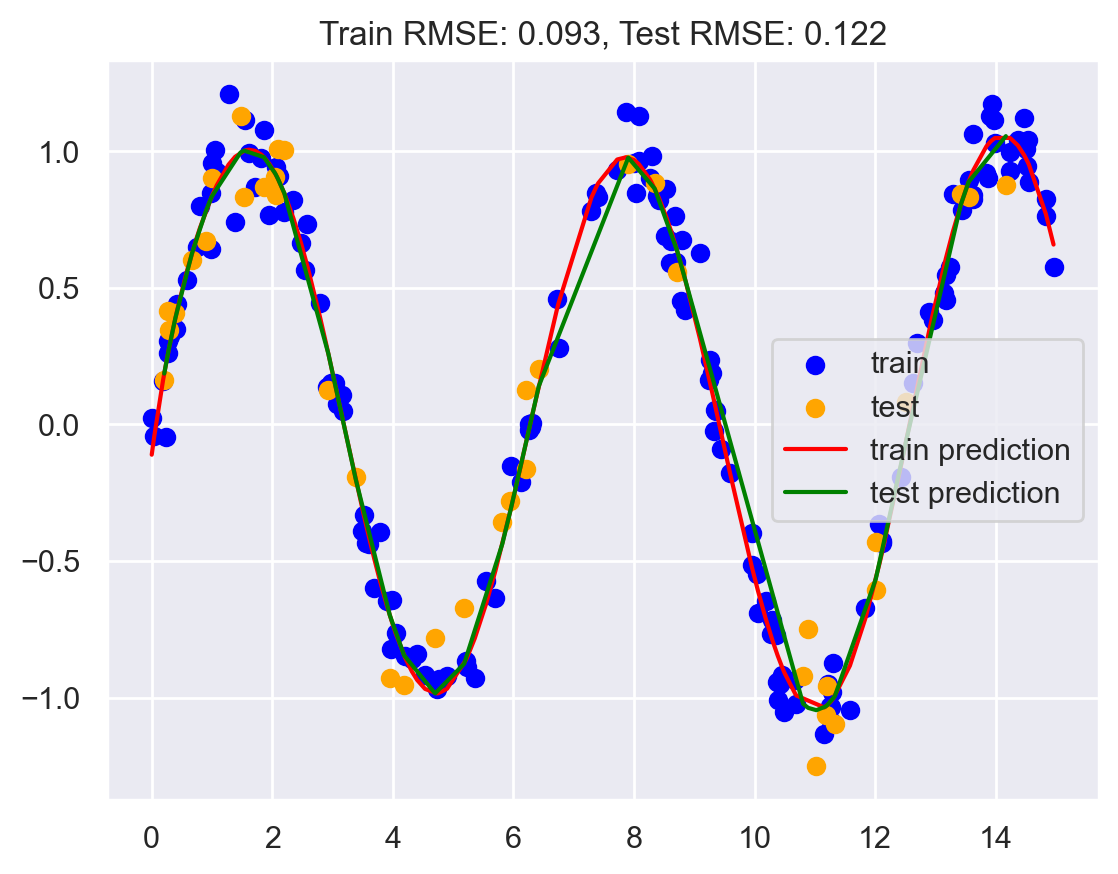

In [13]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
degrees = range(1, 20)
best_degree = hyperparameter_tuning(degrees, train, test, poly_regression)
yhat_train, yhat_test = poly_regression(best_degree, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Polynomial Regression'] = (train_rmse, test_rmse)
print("Best degree: ", best_degree)

### Model 4: Linear regression with sine and cosine basis functions

In [14]:
def sine_basis_regression(num_basis, train, test):
    lr = LinearRegression()
    for i in range(1, num_basis+1):
        train[f"sine_{i}"] = np.sin(i*train.x)
        train[f"cosine_{i}"] = np.cos(i*train.x)
        test[f"sine_{i}"] = np.sin(i*test.x)
        test[f"cosine_{i}"] = np.cos(i*test.x)
    
    X_train = train.drop(['y'], axis=1)
    X_test = test.drop(['y'], axis=1)
    
    lr.fit(X_train, train.y)

    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

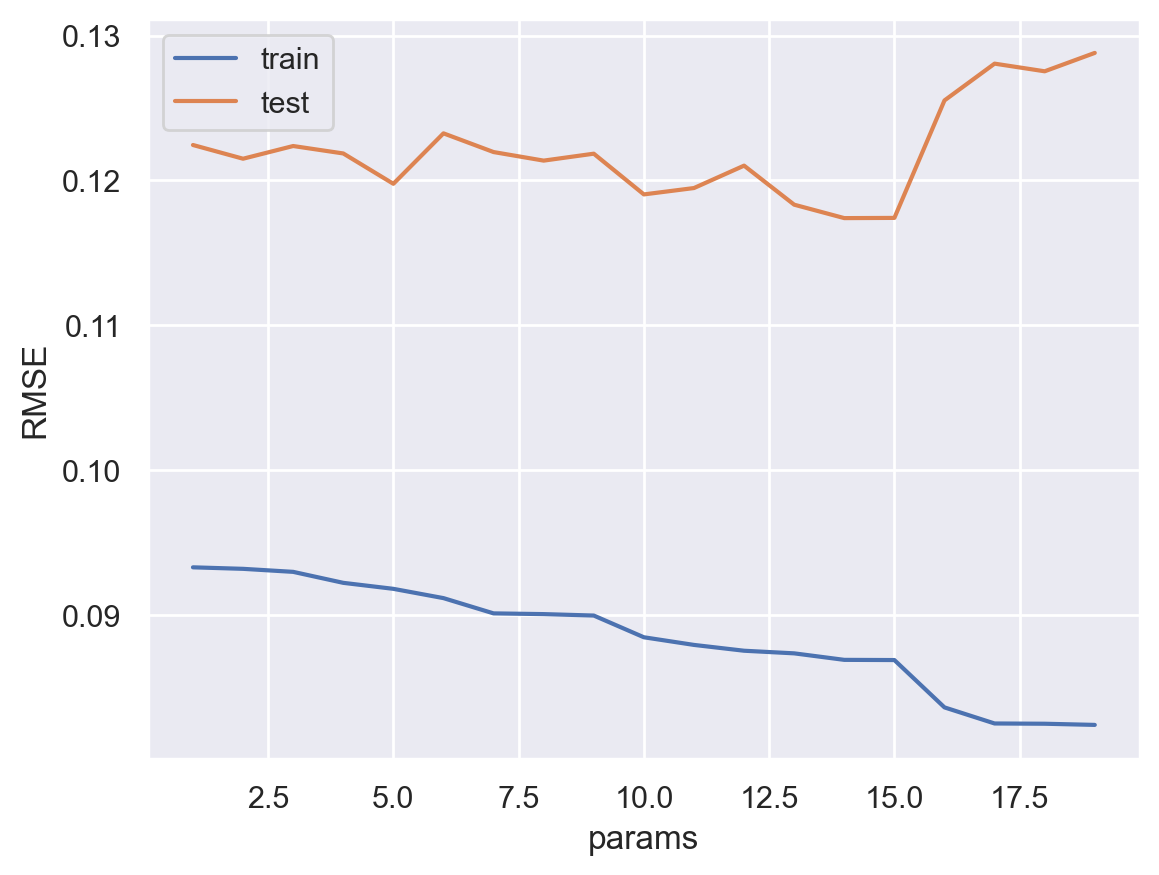

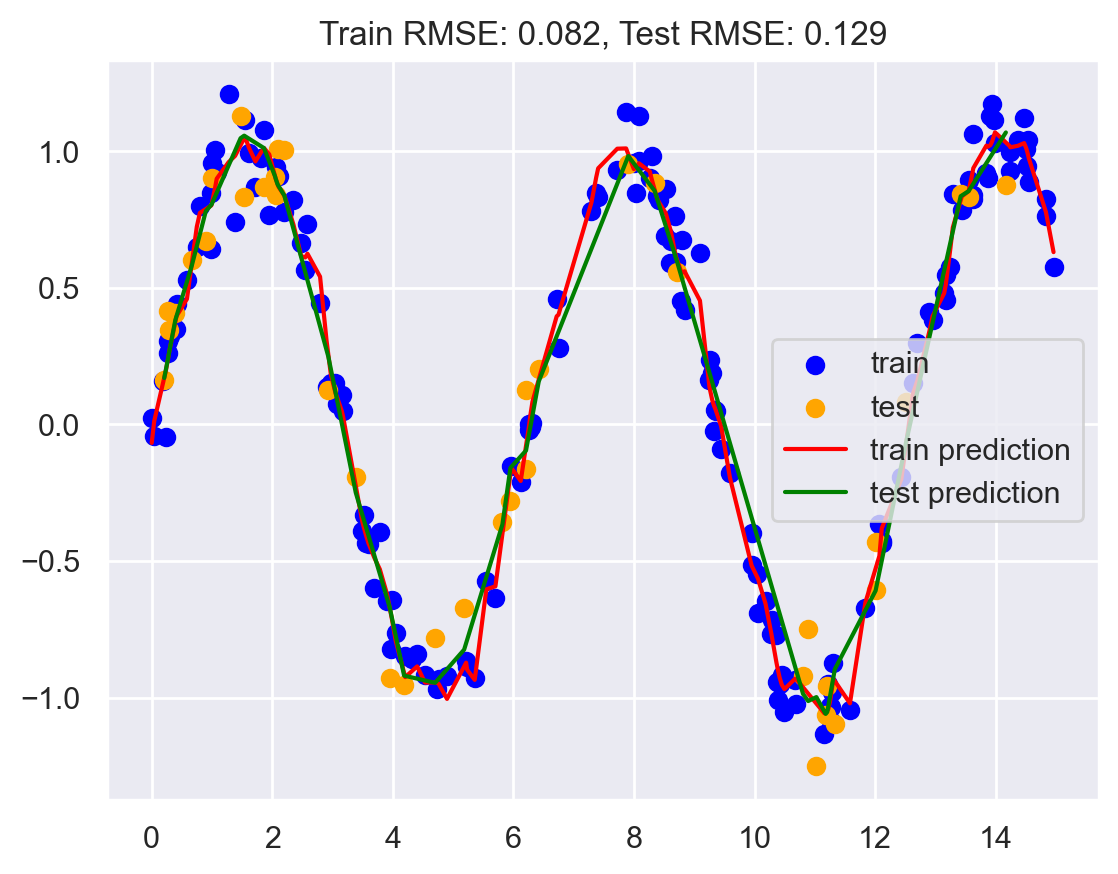

Best number of basis:  14


In [15]:
basis = range(1, 20)
best_num_basis = hyperparameter_tuning(basis, train, test, sine_basis_regression)
yhat_train, yhat_test = sine_basis_regression(best_num_basis, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Sine Basis Regression'] = (train_rmse, test_rmse)
print("Best number of basis: ", best_num_basis)

### Model 5: Linear regression with Gaussian basis functions

In [16]:
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Gaussian-basis-functions

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Uniformly spaced Gaussian features for one-dimensional input
    
    Constructor with N centers and width_factor as hyperparameters
    N comes from the number of basis functions
    width_factor is the width of each basis function
    """
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

Best number of basis:  13


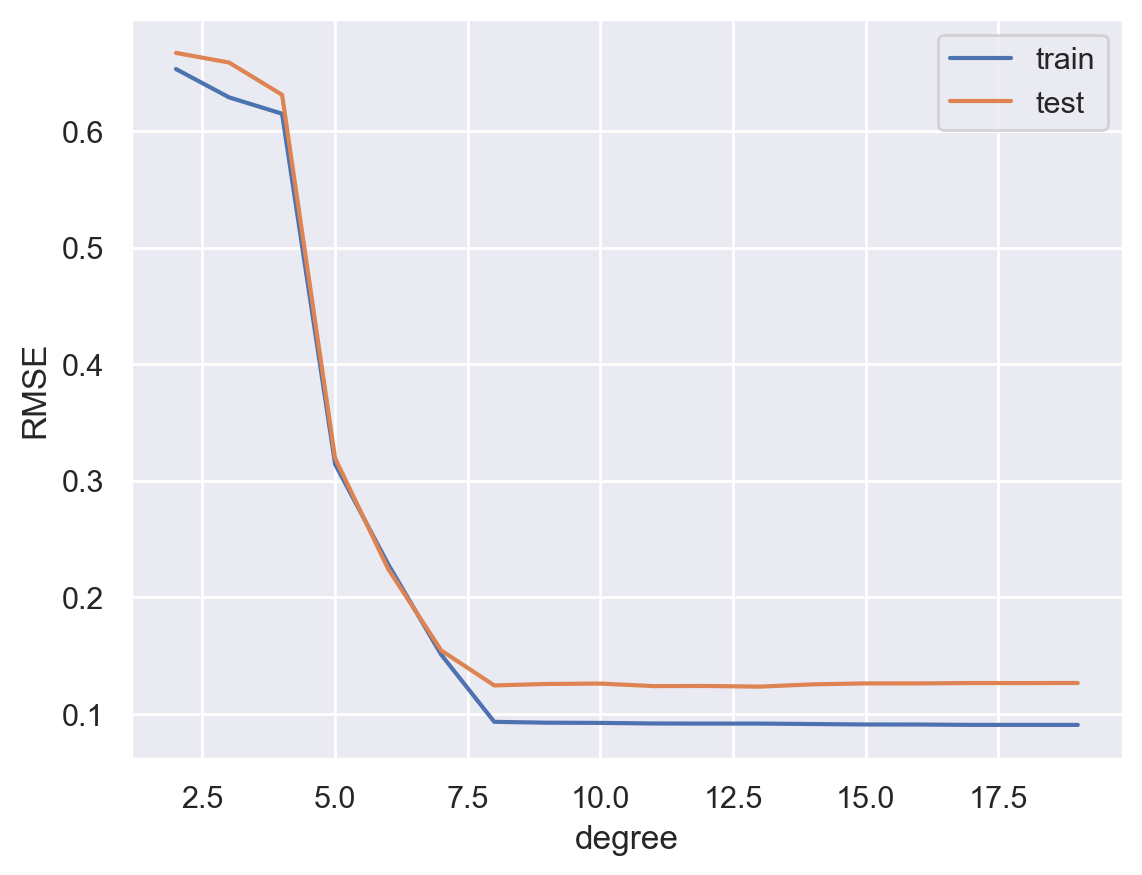

In [17]:
# Hyperparameter tuning
basis = range(2, 20)

train_rmse = []
test_rmse = []
for d in basis:
    model = make_pipeline(GaussianFeatures(d), LinearRegression())
    model.fit(np.array(train.x).reshape(-1, 1), train.y)
    yhat_train = model.predict(np.array(train.x).reshape(-1, 1))
    yhat_test = model.predict(np.array(test.x).reshape(-1, 1))
    train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
    test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

best_num_basis = basis[np.argmin(test_rmse)]
print("Best number of basis: ", best_num_basis)
plt.plot(basis, train_rmse, label='train')
plt.plot(basis, test_rmse, label='test')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

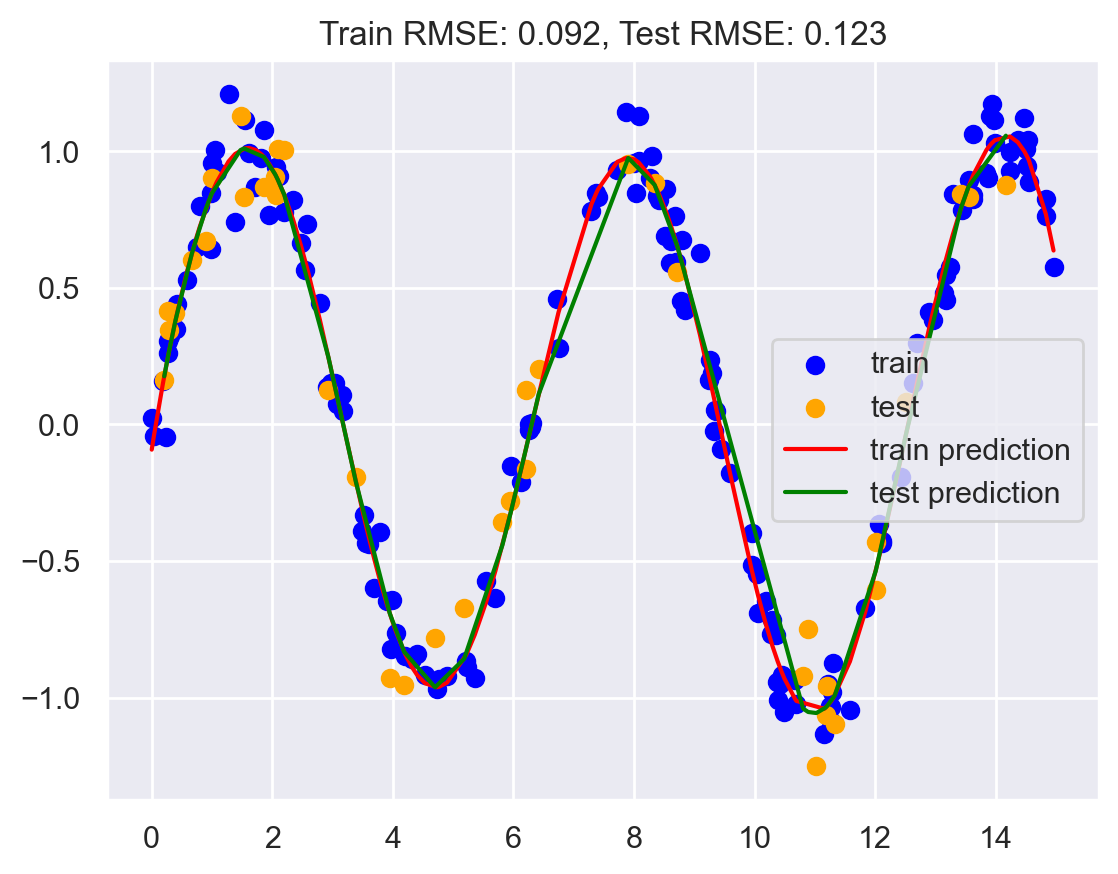

In [18]:
gauss_model = make_pipeline(GaussianFeatures(best_num_basis), LinearRegression())
gauss_model.fit(np.array(train.x).reshape(-1, 1), train.y)
yhat_train = gauss_model.predict(train.x.values.reshape(-1, 1))
yhat_test = gauss_model.predict(test.x.values.reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Gaussian Basis Regression'] = (train_rmse, test_rmse)

#### Plotting rmse using different variants of linear regression

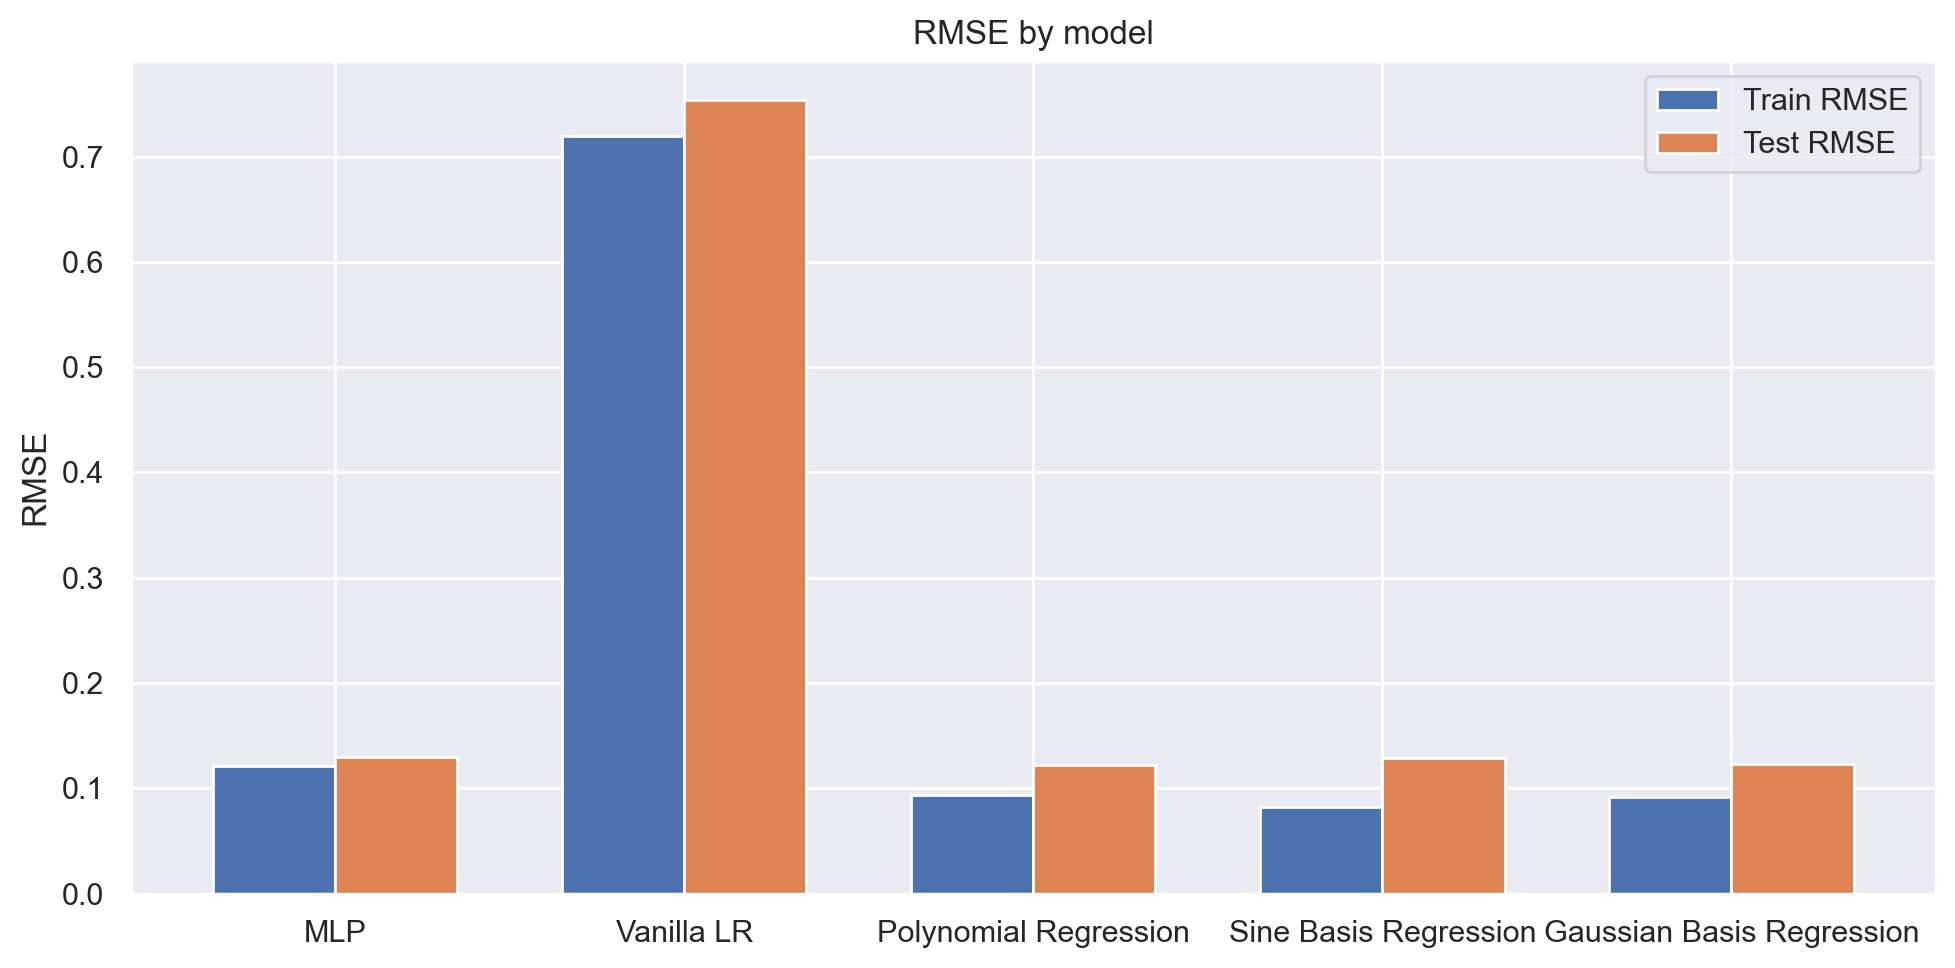

In [21]:
# create a bar plot of train and test RMSE

train_rmse = [rmse_dict[key][0] for key in rmse_dict.keys()]
test_rmse = [rmse_dict[key][1] for key in rmse_dict.keys()]
labels = [key for key in rmse_dict.keys()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
rects2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

# Dataset 2: CO2 Dataset

In [ ]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [ ]:
df

In [ ]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [ ]:
df

In [ ]:
df.average.plot()

In [ ]:
train_cutoff = 2000
train = df[df.year < train_cutoff]
test = df[df.year >= train_cutoff]
df.average.plot()

train.average.plot(color='blue')
test.average.plot(color='orange')

len(train), len(test)

In [ ]:
months_from_start = range(len(df))
months_from_start = np.array(months_from_start).reshape(-1, 1)

In [ ]:
# use sk-learn for MLP

mlp_model = MLPRegressor(hidden_layer_sizes=[512, 512, 512, 512, 512], max_iter = 5000)
mlp_model.fit(months_from_start[:len(train)], train.average.values)

In [ ]:
yhat_train = mlp_model.predict(months_from_start[:len(train)])
yhat_test = mlp_model.predict(months_from_start[len(train):])

yhat_train = pd.Series(yhat_train, index=train.index)
yhat_test = pd.Series(yhat_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
# normalize data

train_scaled = (train - train.mean()) / train.std()
test_scaled = (test - test.mean()) / test.std()
months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

# train_scaled = (train - train.mean()) / train.std()
# test_scaled = (test - test.mean()) / test.std()
# months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

mlp_model = MLPRegressor(hidden_layer_sizes=512, max_iter = 1000)
mlp_model.fit(months_from_start_scaled[:len(train)], train_scaled.average.values)

yhat_train = mlp_model.predict(months_from_start_scaled[:len(train)])
yhat_test = mlp_model.predict(months_from_start_scaled[len(train):])

yhat_train_scaled = pd.Series(yhat_train, index=train.index)
yhat_test_scaled = pd.Series(yhat_test, index=test.index)

yhat_train = yhat_train_scaled * train.std() + train.mean()
# yhat_test = yhat_test_scaled * test.std() + test.mean()


df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 2: Vanilla Linear Regression

In [ ]:
lr1 = LinearRegression()
lr1.fit(months_from_start[:len(train)], train.average.values)
yhat1_test = lr1.predict(months_from_start[len(train):])
yhat1_train = lr1.predict(months_from_start[:len(train)])

yhat_train = pd.Series(yhat1_train, index=train.index)
yhat_test = pd.Series(yhat1_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 3: Polynomial regression with degree d

In [ ]:
def poly_regression(d, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    X_train = pf.fit_transform(months_from_start[:len(train)])
    X_test = pf.fit_transform(months_from_start[len(train):])
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    df.average.plot()
    yhat_train.plot()
    yhat_test.plot()
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_regression(2, train, test)

### Model 4: Linear Regression with sine and cosine basis functions

In [ ]:
### Adding sine and cosine terms
def sine_cosine_features(X, n):
    """
    X: array of shape (n_samples, 1)
    n: number of sine and cosine features to add
    """
    for i in range(1, n+1):
        X = np.hstack([X, np.sin(i*X), np.cos(i*X)])
    return X

In [ ]:
X = np.linspace(-1, 1, 100).reshape(-1, 1)

In [ ]:
_ = plt.plot(X, sine_cosine_features(X, 0))

### Model 5: Gaussian basis functions

### Model 6: Linear Regression with polynomial and sine/cosine basis functions

In [ ]:
def poly_sine_cosine_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = sine_cosine_features(months_from_start[:len(train)], n)
    
    X_test = sine_cosine_features(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_sine_cosine_regression(6, train, test)

### Model 7: Random Fourier Features

In [ ]:
def rff_featurise(X, n_components=100):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    from sklearn.kernel_approximation import RBFSampler
    rbf_feature = RBFSampler(gamma=1, n_components=n_components, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

In [ ]:
def poly_rff_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = rff_featurise(months_from_start[:len(train)], n)
    
    X_test = rff_featurise(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_rff_regression(440, train, test)